In [1]:
## ESSENTIAL for imports and directories --> put it in every notebook in subfolders of src
%cd ..

c:\progetti\Thesis\src


In [2]:
import os, glob, pickle
from tqdm import tqdm
from tqdm.contrib import itertools
import numpy as np
from typing import Literal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(42)

from config_pckg.config_file import Config



C:\Users\ceresini_m\AppData\Local\Temp\ipykernel_29208\2302875177.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# conf = Config()
# meshComplete_paths_no_labels = glob.glob(os.path.join(conf.EXTERNAL_FOLDER_MESHCOMPLETE, "*.pkl"))

# for filename in conf.problematic_files: # used if getting objects from EXTERNAL_FOLDER_MESHCOMPLETE without labels
#     meshComplete_paths_no_labels.remove(os.path.join(conf.EXTERNAL_FOLDER_MESHCOMPLETE, filename+".pkl"))

# meshComplete_objs_no_labels = []

# for filename in meshComplete_paths_no_labels:
#     with open(filename, "rb") as f:
#         meshComplete_objs_no_labels.append(pickle.load(f))

In [4]:
# for obj in tqdm(meshComplete_objs_no_labels):
#     obj.add_labels(os.path.join(conf.EXTERNAL_FOLDER_CSV, obj.name+"_cell_values_at300.csv"))
#     obj.save_to_disk(os.path.join(conf.EXTERNAL_FOLDER_MESHCOMPLETE_W_LABELS, obj.name+".pkl"))

In [5]:
conf = Config()
meshComplete_paths = sorted(glob.glob(os.path.join(conf.EXTERNAL_FOLDER_MESHCOMPLETE_W_LABELS, "*.pkl")))

In [6]:
os.getcwd()

'c:\\progetti\\Thesis\\src'

In [7]:
meshComplete_paths[0]

'K:CFD-WT\\ML_AI\\2D_V01_database\\MeshCompleteObjsWithLabels_at300\\2dtc_001R001_001_s01.pkl'

In [20]:
obj_list = []
for path in tqdm(meshComplete_paths):
    with open(path, "rb") as f:
        obj_list.append(pickle.load(f))

  0%|          | 0/146 [00:00<?, ?it/s]

100%|██████████| 146/146 [03:39<00:00,  1.50s/it]


In [24]:
import pyvista
pl = pyvista.Plotter()
pl.add_mesh(obj_list[5].mesh, lighting=False, edge_color="black")
pl.camera_position ="xy"
pl.show()

Widget(value='<iframe src="http://localhost:57689/index.html?ui=P_0x183bc2b8410_7&reconnect=auto" class="pyvis…

In [28]:
pl = pyvista.Plotter(shape=(2,3))
pl.subplot(0,0)
pl.add_mesh(obj_list[3].mesh, lighting=False, show_edges=True, edge_color="black")
pl.camera_position = "xy"
pl.subplot(0,1)
pl.add_mesh(obj_list[11].mesh, lighting=False, show_edges=True, edge_color="black")
pl.camera_position = "xy"
pl.subplot(0,2)
pl.add_mesh(obj_list[45].mesh, lighting=False, show_edges=True, edge_color="black")
pl.camera_position = "xy"
pl.subplot(1,0)
pl.add_mesh(obj_list[49+13].mesh, lighting=False, show_edges=True, edge_color="black")
pl.camera_position = "xy"
pl.subplot(1,1)
pl.add_mesh(obj_list[49+47].mesh, lighting=False, show_edges=True, edge_color="black")
pl.camera_position = "xy"
pl.subplot(1,2)
pl.add_mesh(obj_list[-1].mesh, lighting=False, show_edges=True, edge_color="black")
pl.camera_position = "xy"
pl.link_views()
pl.show()

Widget(value='<iframe src="http://localhost:57689/index.html?ui=P_0x18388cab350_11&reconnect=auto" class="pyvi…

In [17]:
position = pl.camera.position
zoom = pl.camera.zoom
# pl.camera.position = position
# pl.camera.zoom = zoom

In [19]:
pl1 = pyvista.Plotter()
pl1.add_mesh(obj_list[1].mesh, lighting=False, show_edges=True)
pl1.camera_position = "xy"
pl1.camera.zoom= zoom
pl1.camera.position= position
pl1.show()

Widget(value='<iframe src="http://localhost:57689/index.html?ui=P_0x17f4e037410_3&reconnect=auto" class="pyvis…

In [21]:
graph.x.mean(dim=0)

tensor([2.0371e-02, 2.1541e-02, 4.1096e-01, 3.8434e-02, 8.0883e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 7.5811e+00, 4.2485e-02])

In [22]:
obj.face_center_features.shape[0] == graph.x.shape[0]

True

: 

In [ ]:
# TODO: remove dist_from_BC from graph_node_final_features. Remove feature from graphs and 
# TODO: add it to meshCI. Also the creation needs to go in meshCI

In [6]:
# meshComplete_objs = []

# for path in tqdm(meshComplete_paths):
#     with open(path, "rb") as f:
#         meshComplete_objs.append(pickle.load(f))

In [7]:
with open(meshComplete_paths[0], "rb") as f:
    obj = pickle.load(f)

graph = obj.get_graph()

c:\Users\ceresini_m\github\Thesis\env_Thesis\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


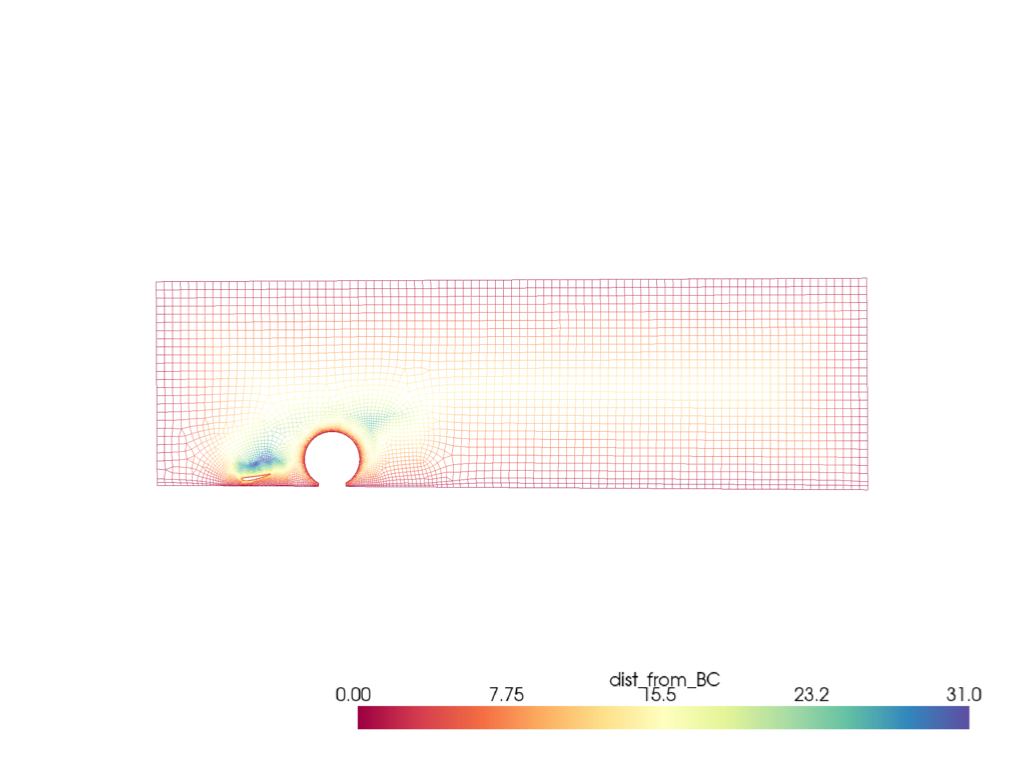

In [10]:
obj.plot_mesh([("face", "label", "dist_from_BC")])

In [ ]:
for obj in meshComplete_objs:
    
    obj.save_to_disk(os.path.join(conf.EXTERNAL_FOLDER_MESHCOMPLETE_W_LABELS, obj.name+".pkl"))

data = test_dataloader.dataset[0]

adj = torch_geometric.utils.to_dense_adj(data.edge_index)[0].numpy().astype(np.float64)
rust_g = rustworkx.PyGraph.from_adjacency_matrix(adj)
print(time())
distance_matrix = rustworkx.distance_matrix(rust_g, parallel_threshold=10000)
# a = to_networkx(data)
print(time())
########
bc_nodes_list = []
other_nodes = []
n_nodes = data.x.shape[0]
for i, mask in enumerate(data.x_mask):
    if sum(mask) >= 4:
        bc_nodes_list.append(i)
    else:
        other_nodes.append(i)

dist_from_bc_per_node = np.min(distance_matrix[:, np.array(bc_nodes_list)], axis=1)
max_dist_from_bc = np.max(dist_from_bc_per_node)

data["dist_from_bc"] = dist_from_bc_per_node
data["max_dist_from_bc"] = max_dist_from_bc

In [7]:
# import utils
# obj = meshComplete_objs[0]

# conf_dict1 = conf.label_normalization_mode
# conf_dict2 = conf_dict1.copy()
# conf_dict2.update({"velocity_mode":"component_wise"})
# conf_dict3 = conf_dict1.copy()
# conf_dict3.update({"main":"Physical"})

# lab1 = utils.normalize_labels(obj.face_center_labels, conf_dict1, conf)
# lab2 = utils.normalize_labels(obj.face_center_labels, conf_dict2, conf)
# lab3 = utils.normalize_labels(obj.face_center_labels, conf_dict3, conf)

In [8]:
def get_interesting_info(obj_list, mode:Literal["geometry", "labels"] = "geometry"):

    match mode:
        case "geometry":
            interesting_df = pd.DataFrame({
                "n_points": [m.mesh.points.shape[0] for m in obj_list],
                "n_faces": [m.face_center_positions.shape[0] for m in obj_list],
                "n_cells": [m.cell_center_positions.shape[0] for m in obj_list],
                "n_CcCc_edges": [m.CcCc_edges_bidir.shape[0]/2 for m in obj_list],
                "n_FcFc_edges": [m.FcFc_edges.shape[0] for m in obj_list],
                "n_CcFc_edges": [m.CcFc_edges.shape[0] for m in obj_list],
                "avg_vertices_in_face": [np.mean([len(face_vertices) for face_vertices in m.vertices_in_faces]) for m in obj_list],
                "avg_vertices_in_cell": [np.mean([len(cell_vertices) for cell_vertices in m.vertices_in_cells]) for m in obj_list],
                "group": [1 if "2dtc_001R" in m.path else 2 for m in obj_list]
            })

        case "labels":
            interesting_df = pd.DataFrame({
                col: [m.face_center_labels[col].mean() for m in obj_list] 
                    for col in obj_list[0].face_center_labels.columns})
            interesting_df["v_mag"] = [np.linalg.norm(m.face_center_labels[["x-velocity", "y-velocity"]], axis=1).mean() for m in obj_list]
            interesting_df["group"] = [1 if "2dtc_001R" in m.path else 2 for m in obj_list]
            
    return interesting_df


In [9]:
pd.set_option('display.float_format', '{:.2g}'.format)

In [10]:
info_complete = get_interesting_info(meshComplete_objs)
info_complete.describe()

,n_points,n_faces,n_cells,n_CcCc_edges,n_FcFc_edges,n_CcFc_edges,avg_vertices_in_face,avg_vertices_in_cell,group
count,1.5e+02,1.5e+02,1.5e+02,1.5e+02,1.5e+02,1.5e+02,1.5e+02,1.5e+02,1.5e+02
mean,2.1e+04,4.3e+04,2.1e+04,4.1e+04,1.2e+05,8.3e+04,2,3.9,1.7
std,3.3e+03,6.5e+03,3.2e+03,6.2e+03,1.9e+04,1.3e+04,0,0.042,0.47
min,1.5e+04,3.2e+04,1.6e+04,3e+04,8.7e+04,6.2e+04,2,3.8,1
25%,1.7e+04,3.4e+04,1.7e+04,3.2e+04,9.6e+04,6.6e+04,2,3.9,1
50%,2.3e+04,4.7e+04,2.4e+04,4.5e+04,1.3e+05,9.2e+04,2,3.9,2
75%,2.4e+04,4.7e+04,2.4e+04,4.5e+04,1.4e+05,9.2e+04,2,3.9,2
max,2.4e+04,4.7e+04,2.4e+04,4.5e+04,1.4e+05,9.3e+04,2,3.9,2


In [11]:
def boxplot_by(df, by):
    chosen_columns = list(df.columns.difference(["group", "split"]))
    fig, axs = plt.subplots(1,len(chosen_columns), figsize=(20, 7))
    for i, column in enumerate(chosen_columns):
        axs[i].tick_params("y", direction="in", pad=0, labelsize=7, labelrotation=90)
        df.boxplot(column, ax=axs[i], by=by)

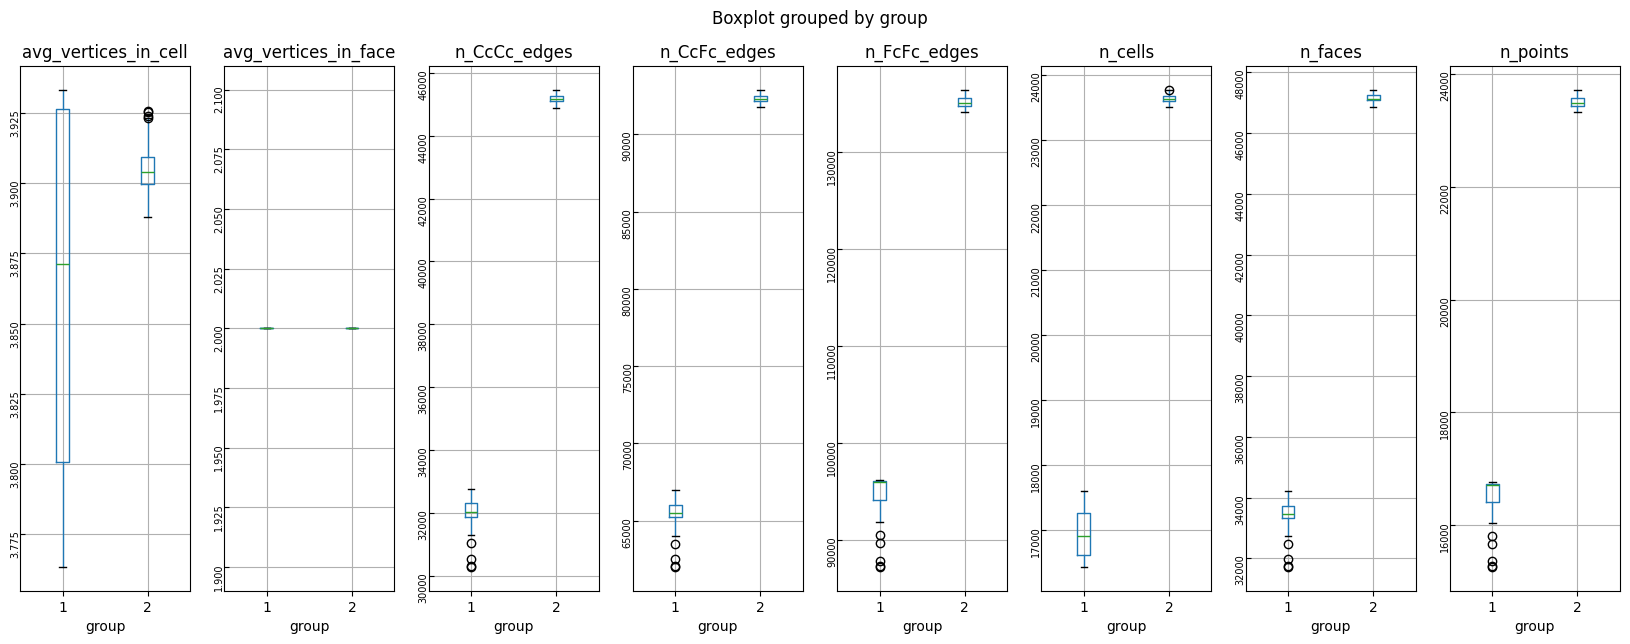

In [12]:
boxplot_by(info_complete, "group")

In [13]:
def get_splits_from_idxs(idxs, splits=(0.8, 0.1)):
    train_split = list(np.random.choice(list(idxs), 
                                   int(np.floor(splits[0]*len(idxs))),
                                   replace=False))
    val_split = list(np.random.choice(list(idxs.difference(set(train_split))), 
                                 int(np.floor(splits[1]*len(idxs))),
                                 replace=False))
    test_split = list(idxs.difference(set(train_split)).difference(set(val_split)))

    return train_split, val_split, test_split

def generate_train_val_test_splits(info_complete, splits=(0.8, 0.1)):
    flap1_idxs = set(np.arange(len(info_complete))[info_complete["group"]==1])
    train_flap1, val_flap1, test_flap1 = get_splits_from_idxs(flap1_idxs, splits)
    flap2_idxs = set(np.arange(len(info_complete))[info_complete["group"]==2])
    train_flap2, val_flap2, test_flap2 = get_splits_from_idxs(flap2_idxs, splits)

    train_split = train_flap1 + train_flap2
    val_split = val_flap1 + val_flap2
    test_split = test_flap1 + test_flap2

    split_type = pd.api.types.CategoricalDtype(ordered= True, categories=["train", "val", "test"])
    split_series = pd.Series(np.zeros_like(info_complete["group"]))
    split_series[train_split] = "train"
    split_series[val_split] = "val"
    split_series[test_split] = "test"
    split_series = split_series.astype(split_type)
    
    return split_series


In [14]:
split_series = generate_train_val_test_splits(info_complete)
split_series.value_counts()

train    116
test      17
val       13
Name: count, dtype: int64

In [15]:
split_idxs = {
    "train": split_series[split_series=="train"].index,
    "val": split_series[split_series=="val"].index,
    "test": split_series[split_series=="test"].index,
}

In [16]:
with open(os.path.join(conf.ROOT_DIR, "src", "config_pckg", "splits.pkl"), "wb") as f:
    pickle.dump(split_idxs, f)

In [17]:
train_objs = [meshComplete_objs[i] for i in split_series[split_series=="train"].index]

vx, vy, p, v_mag = [], [], [], []

for obj in train_objs:
    vx.append(obj.face_center_labels["x-velocity"])
    vy.append(obj.face_center_labels["y-velocity"])
    p.append(obj.face_center_labels["pressure"])
    v_mag.append(np.linalg.norm(obj.face_center_labels[["x-velocity", "y-velocity"]], axis=1))

vx = np.concatenate(vx)
vy = np.concatenate(vy)
p = np.concatenate(p)
v_mag = np.concatenate(v_mag)

dataset_label_stats = {"mean": {
    "x-velocity": vx.mean(),
    "y-velocity": vy.mean(),
    "pressure": p.mean(),
    "v_mag": v_mag.mean(),
}, "std": {
    "x-velocity": vx.std(),
    "y-velocity": vy.std(),
    "pressure": p.std(),
    "v_mag": v_mag.std(),
}}

with open(os.path.join(conf.ROOT_DIR, "src", "config_pckg", "dataset_label_stats.pkl"), "wb") as f:
    pickle.dump(dataset_label_stats, f)

In [18]:
info_complete["split"] = split_series

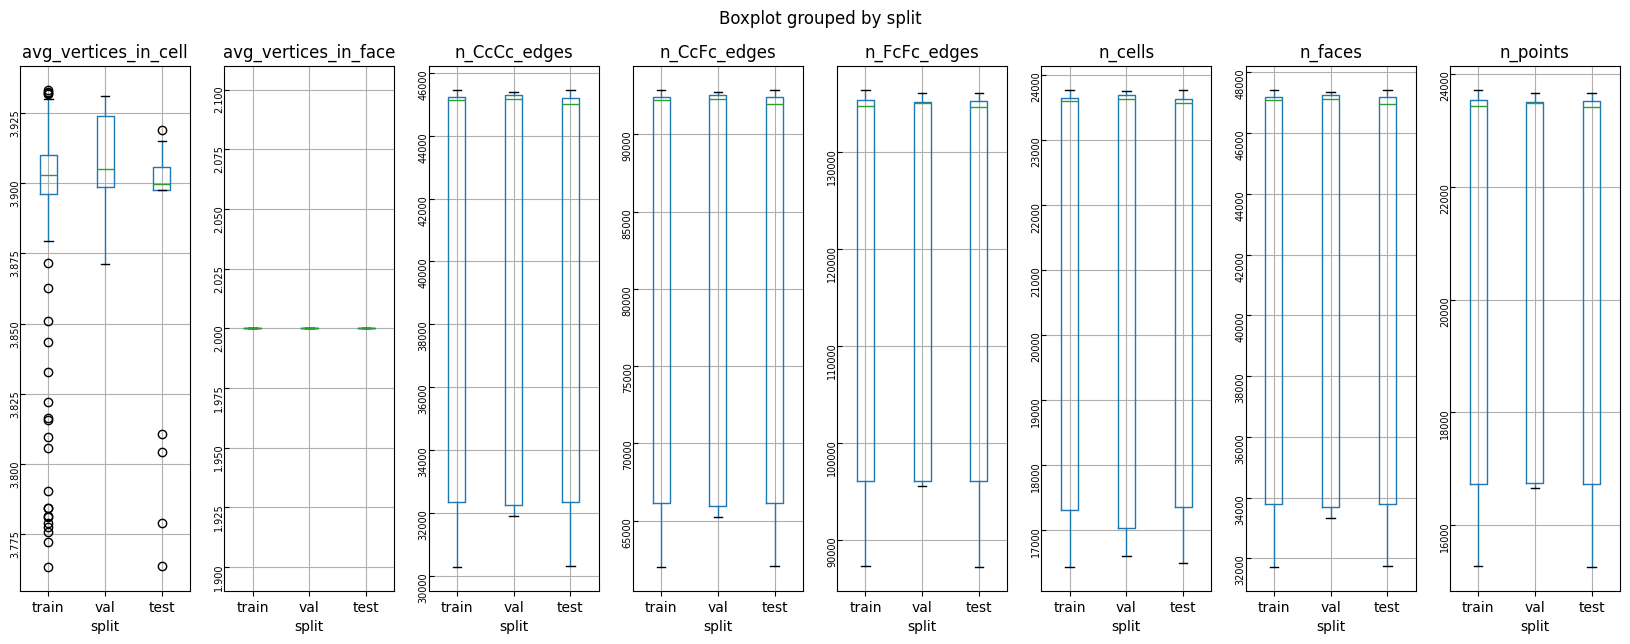

In [19]:
boxplot_by(info_complete, "split")

In [20]:
# errors = []
# for meshComplete_obj in (pbar := tqdm(meshComplete_objs)):
#     try:
#         name = meshComplete_obj.path.split(os.sep)[-1].removesuffix(".pkl")
#         pbar.set_description(name)
#         last_csv = glob.glob(os.path.join(conf.EXTERNAL_FOLDER_CSV, name+"*_at300.csv"))
#         if len(last_csv) == 1:
#             path_csv = last_csv[0]
#         meshComplete_obj.add_labels(path_csv)
#     except Exception as e:
#         print(e, name)
#         errors.append(name)

In [21]:
# from scipy.spatial.distance import cdist
# pts = meshComplete_objs[0].mesh.points
# m = cdist(pts, pts)
# ma = np.ma.masked_array(m, mask=np.eye(m.shape[0]))
# np.min(ma)

In [22]:
label_info = get_interesting_info(meshComplete_objs, mode="labels")
label_info["split"] = split_series

In [23]:
# meshComplete_objs[0].plot_mesh([("cell", "label", "x-velocity")])

In [24]:
# meshComplete_objs[1].plot_mesh([("cell", "label", "x-velocity")])

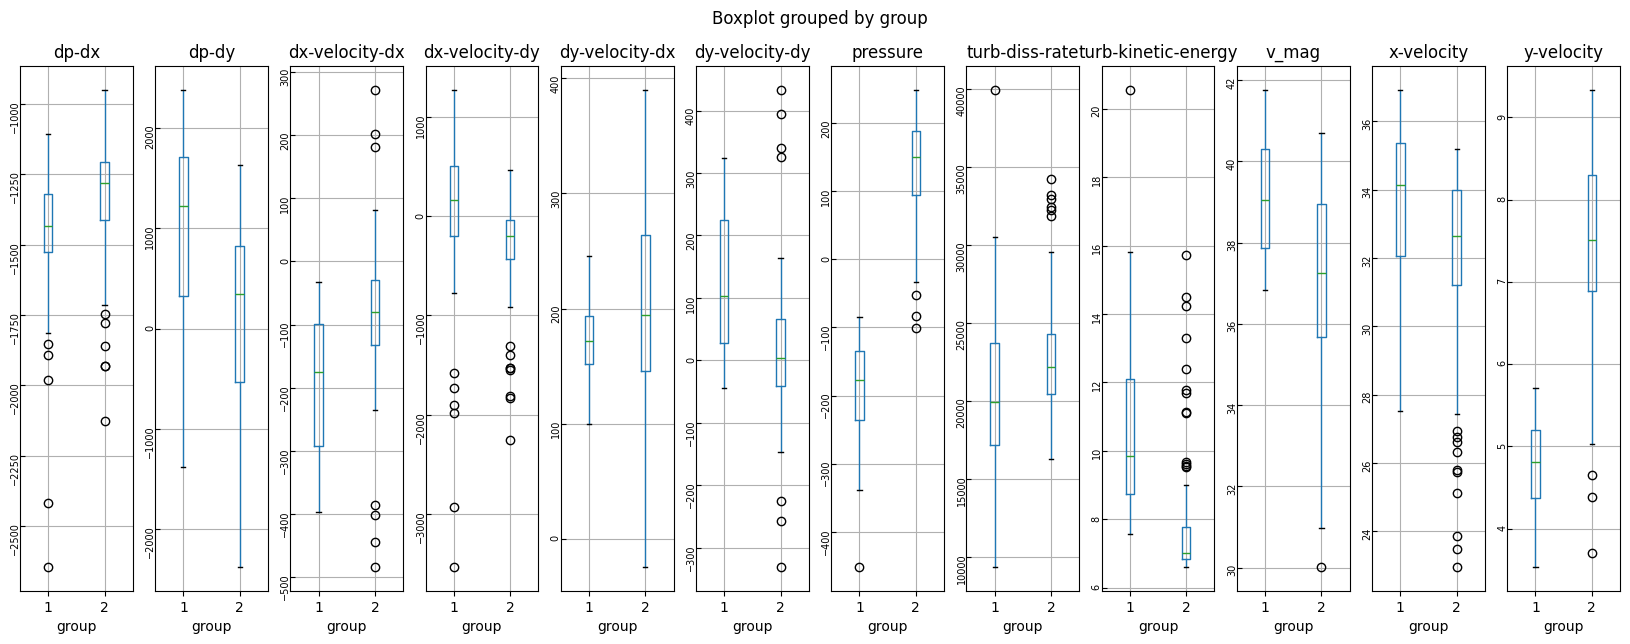

In [25]:
boxplot_by(label_info, "group")

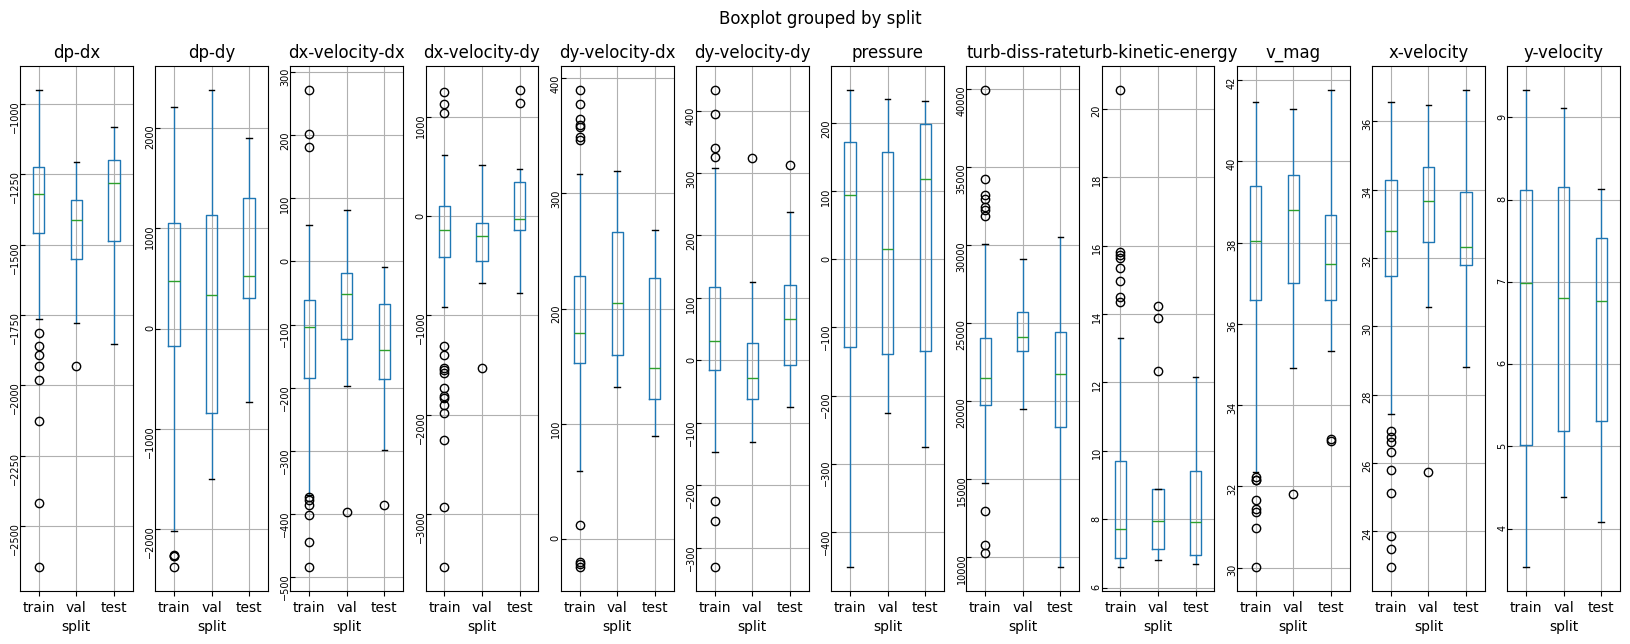

In [26]:
boxplot_by(label_info, "split")

In [19]:
from scipy.interpolate import griddata
from time import time

mesh_1_points = meshComplete_objs[0].face_center_positions[:,:2]
mesh_1_values = meshComplete_objs[0].face_center_labels["pressure"].values
mesh_2_points = meshComplete_objs[0].face_center_positions[:,:2]

In [20]:
for method in ["nearest", "linear", "cubic"]:
    tic=time()
    mesh_2_interpolated_values = griddata(
        points=mesh_1_points,
        values=mesh_1_values,
        xi=mesh_2_points,
        method=method,
    )

    loss = np.sqrt(np.sum(np.square(meshComplete_objs[0].face_center_labels["pressure"].values - mesh_2_interpolated_values)))
    print(f"Method: {method}, time: {time()-tic:.1f}, RMSE: {loss:.3e}")


Method: nearest, time: 0.1, RMSE: 0.000e+00
Method: linear, time: 2.9, RMSE: 2.130e-04
Method: cubic, time: 3.2, RMSE: 3.883e-05


In [63]:
def get_loss_matrix(meshComplete_objs, label, normalized=False, relative=False):
    n_meshes = len(meshComplete_objs)
    loss_matrix = np.zeros((n_meshes, n_meshes))

    for i, j in itertools.product(range(n_meshes), range(n_meshes)):
            mesh_1_points = meshComplete_objs[i].face_center_positions[:,:2]
            mesh_1_values = meshComplete_objs[i].face_center_labels[label].values

            if normalized: # FIXME: normalization should be label-wise (ex. pressure should be maybe centered around 1atm with std=1?)
                mesh_1_values /= np.max(mesh_1_values)

            mesh_2_points = meshComplete_objs[j].face_center_positions[:,:2]

            # griddata (in linear mode) creates Delaunay triangles from "points" and then interpolates to each point in xi from the 3 vertices that enclose it. 
            mesh_2_interpolated_values = griddata(
                points=mesh_1_points,
                values=mesh_1_values,
                xi=mesh_2_points,
                method="nearest",
            )

            loss = np.sqrt(np.mean(np.square(
                meshComplete_objs[j].face_center_labels[label].values - mesh_2_interpolated_values
            )))

            if relative:
                loss /= np.sqrt(np.mean(np.square(meshComplete_objs[j].face_center_labels[label].values)))

            loss_matrix[i,j] = loss
    
    return loss_matrix

In [73]:
pressure_loss_matrix = get_loss_matrix(meshComplete_objs, "pressure")

100%|██████████| 21316/21316 [25:48<00:00, 13.76it/s]


<Axes: >

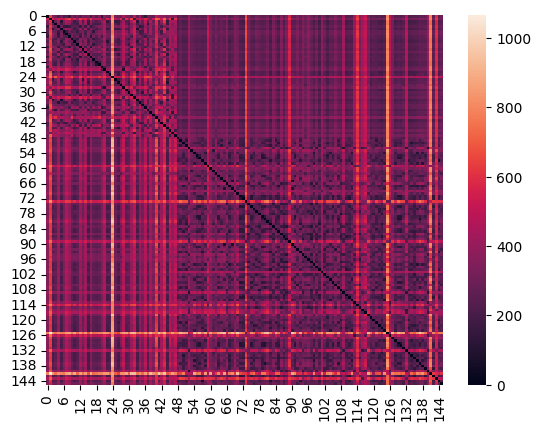

In [74]:
sns.heatmap(pressure_loss_matrix)

<Axes: >

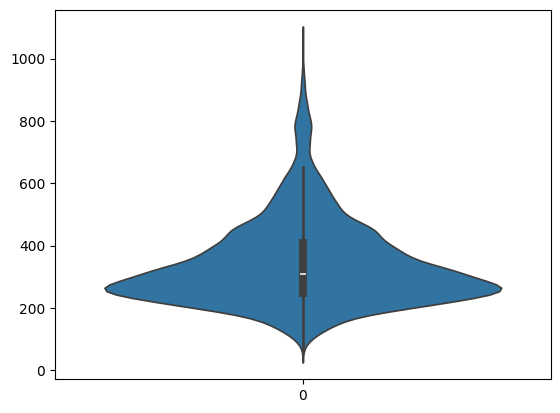

In [75]:
ma = np.ma.masked_array(pressure_loss_matrix, mask=np.eye(pressure_loss_matrix.shape[0]))

sns.violinplot(pd.DataFrame(ma[ma.mask == False]))


In [80]:
ma.mean() / np.mean([np.mean(np.abs(obj.face_center_labels["pressure"])) for obj in meshComplete_objs])


0.310532891120709

In [77]:
last_1flap = np.max(info_complete[info_complete['group']==1].index) + 1

In [78]:
print(f"Mean loss between 1 flap {np.ma.sum(ma[:last_1flap, :last_1flap]) / np.ma.count(ma[:last_1flap, :last_1flap]):.3e}")
print(f"Mean loss between 2 flap {np.ma.sum(ma[last_1flap:, last_1flap:]) / np.ma.count(ma[last_1flap:, last_1flap:]):.3e}")
print(f"Mean loss between 1 and 2 flaps { (np.ma.sum(ma[:last_1flap, last_1flap:]) + np.ma.sum(ma[last_1flap:, :last_1flap])) / (np.ma.count(ma[:last_1flap, last_1flap:]) + np.ma.count(ma[last_1flap:, :last_1flap])):.3e}")

print(f"N computed losses 1 flap {np.ma.count(ma[:last_1flap, :last_1flap]):.0f}")
print(f"N computed losses 2 flap {np.ma.count(ma[last_1flap:, last_1flap:]):.0f}")
print(f"N computed losses 1vs2 flap {(np.ma.count(ma[:last_1flap, last_1flap:]) + np.ma.count(ma[last_1flap:, :last_1flap])):.0f}")


Mean loss between 1 flap 3.621e+02
Mean loss between 2 flap 3.258e+02
Mean loss between 1 and 2 flaps 3.534e+02
N computed losses 1 flap 2256
N computed losses 2 flap 9506
N computed losses 1vs2 flap 9408


In [79]:
np.mean([np.mean(np.abs(obj.face_center_labels["pressure"])) for obj in meshComplete_objs])

1101.2437297901768

In [ ]:
complete_label_loss_matrices = {key: get_loss_matrix(meshComplete_objs, key) for key in meshComplete_objs[0].face_center_labels.columns}

In [ ]:
with open(conf.EXTERNAL_FOLDER_GENERIC+"loss_matrices_dict.pkl", "wb") as f:
    pickle.dump(complete_label_loss_matrices, f)

In [ ]:
baseline_losses = {key: np.mean(np.ma.masked_array(value, mask=np.eye(value.shape[0]))) for key, value in complete_label_loss_matrices.items()}

In [94]:
meshComplete_objs[74].name

'2dtc_002R027_001_s01'

In [96]:
with open(os.path.join(conf.EXTERNAL_FOLDER_MESHCOMPLETE_W_LABELS, "2dtc_002R027_001_s01.pkl"), "rb") as f:
    obj = pickle.load(f)

In [98]:
obj.cell_center_positions.shape

(23635, 3)

In [125]:
def loss(prediction, labels, mode:Literal["RMSE", "RRMSE"]="RMSE"):
    eps = np.finfo(float).eps
    match mode:
        case "RMSE":
            return np.sqrt(np.mean(np.square(
                prediction - labels
            )))
        case "RRMSE":
            return np.sqrt(
                np.mean(np.square(prediction - labels)) / (np.sum(np.square(prediction))+eps)
            )

In [126]:
mesh_1_points = meshComplete_objs[0].face_center_positions[:,:2]
mesh_1_values = meshComplete_objs[0].face_center_labels["pressure"].values

mesh_2_points = meshComplete_objs[1].face_center_positions[:,:2]

# griddata (in linear mode) creates Delaunay triangles from "points" and then interpolates to each point in xi from the 3 vertices that enclose it. 
mesh_2_interpolated_values = griddata(
    points=mesh_1_points,
    values=mesh_1_values,
    xi=mesh_2_points,
    method="nearest",
)

mesh_2_values = meshComplete_objs[1].face_center_labels["pressure"].values

array([[<Axes: title={'center': 'pressure'}>]], dtype=object)

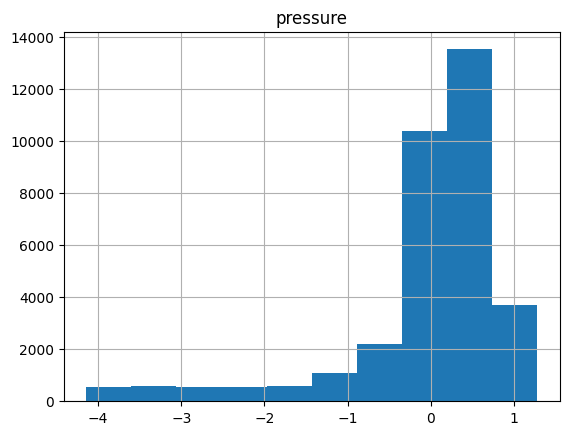

In [134]:
df = pd.DataFrame(meshComplete_objs[1].face_center_labels["pressure"] )
normalized_df=(df-df.mean())/df.std()
normalized_df.hist()

array([[<Axes: title={'center': 'x-velocity'}>]], dtype=object)

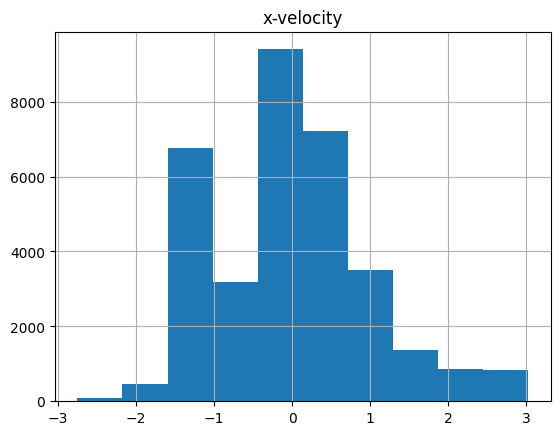

In [135]:
df = pd.DataFrame(meshComplete_objs[1].face_center_labels["x-velocity"] )
normalized_df=(df-df.mean())/df.std()
normalized_df.hist()

array([[<Axes: title={'center': 'y-velocity'}>]], dtype=object)

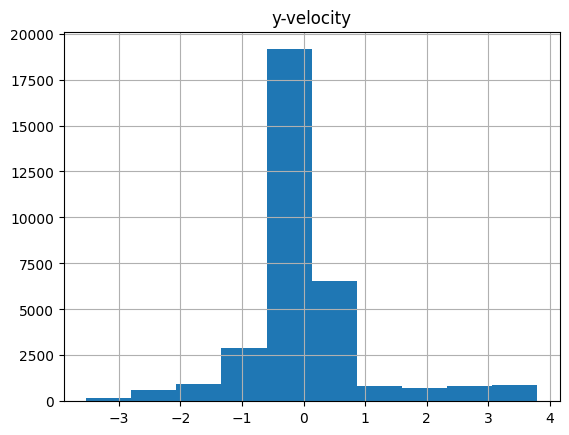

In [136]:
df = pd.DataFrame(meshComplete_objs[1].face_center_labels["y-velocity"] )
normalized_df=(df-df.mean())/df.std()
normalized_df.hist()

In [127]:
for mode in ["RMSE", "RMSRE", "RRMSE", "RMSRE_label", "RRMSE_label"]:
    l = loss(mesh_2_interpolated_values, mesh_2_values, mode)
    print(mode, l)

RMSE 646.5483167869373
RMSRE 5.776940706014537
RRMSE 0.0019472053037708197
RMSRE_label 17.157085607721672
RRMSE_label 0.0019132566172084386


In [117]:
mesh_1_points = meshComplete_objs[0].face_center_positions[:,:2]
mesh_1_values = meshComplete_objs[0].face_center_labels["pressure"].values / (conf.air_speed**2/2)

mesh_2_points = meshComplete_objs[1].face_center_positions[:,:2]

# griddata (in linear mode) creates Delaunay triangles from "points" and then interpolates to each point in xi from the 3 vertices that enclose it. 
mesh_2_interpolated_values = griddata(
    points=mesh_1_points,
    values=mesh_1_values,
    xi=mesh_2_points,
    method="nearest",
)

mesh_2_values = meshComplete_objs[1].face_center_labels["pressure"].values / (conf.air_speed**2/2)

In [118]:
for mode in ["RMSE", "RMSRE", "RRMSE"]:
    l = loss(mesh_2_interpolated_values, mesh_2_values, mode)
    print(mode, l)

RMSE 0.5172386534295498
RMSRE 5.776940706768095
RRMSE 0.0019472053037708195
